# Model Agricultural Soil Moisture

In [2]:
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from das_util import get_tstamp
from scipy.ndimage import gaussian_filter1d

data_dir='/fd1/QibinShi_data/England_farm/'
matplotlib.rcParams.update({'font.size': 16})

## Data 1: 
#### Soil moisture (Ch. 62), soil temperature, proxy of rainfall, and velocity change

PSD correction (time variable)

Text(1443, 0.8, 'sunset')

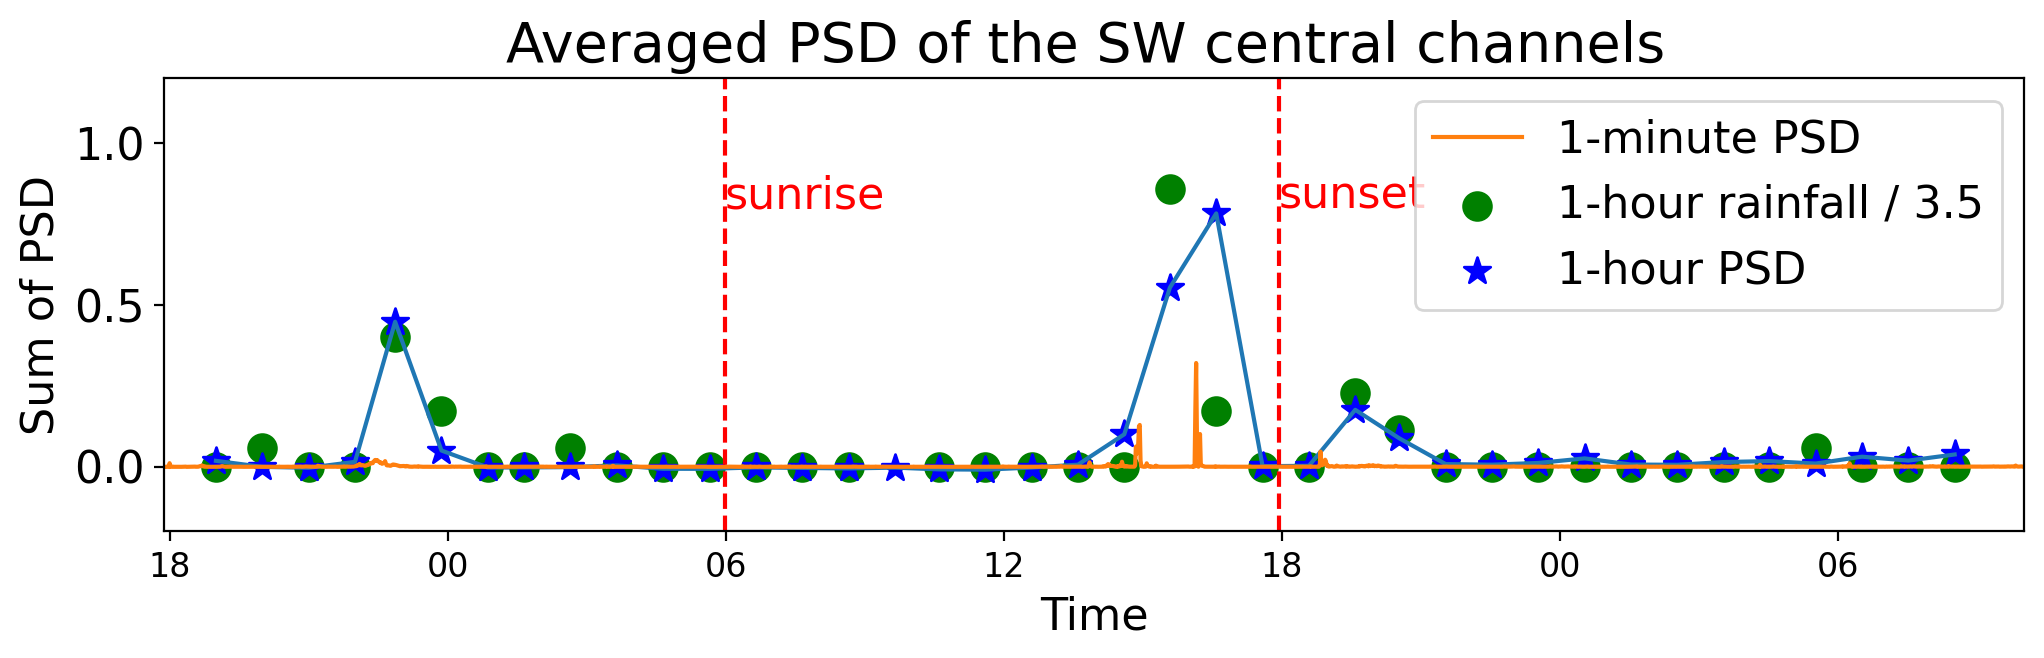

In [5]:
csv_file = pd.read_csv('NewportSalop_merged.csv', low_memory=False).dropna(axis='columns', how='all')
## Index for soil measurements
j = 32
# print(csv_file['Time'][j:j+40])

humidity=csv_file['Humidity'][j+1:j+40].to_numpy()
soil_temp_10=csv_file[' 10cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_30=csv_file['30cm Soil Temperature'][j+1:j+40].to_numpy()
soil_temp_100=csv_file['100cm Soil Temperature'][j+1:j+40].to_numpy()
rainfall=csv_file[' Rainfall Total since 0900'][j:j+40].to_numpy()
rain_diff=np.diff(rainfall)

air_temp = csv_file['Dry Bulb Temperature'][j+1:j+40].to_numpy()
dew_temp = csv_file['Dew Point Temperature'][j+1:j+40].to_numpy()
grs_temp = csv_file['Grass Temperature'][j+1:j+40].to_numpy()

with h5py.File('/fd1/QibinShi_data/England_farm/psd_all.hdf5', 'r') as f:
    file_list = f['daslist'][:].astype('U')
    PSD_all_time = f['psd_all_time'][:]
    freq = f['frequency'][:]
    
acqu_time = np.array([get_tstamp(i) for i in file_list])
start_file = np.arange(0, len(acqu_time), 5)
time_stamps = acqu_time[start_file]

## Mean PSD over channels
ave_psd=np.mean(np.sum(PSD_all_time[0:44, :, 52:90], axis=-1) * (freq[1]-freq[0]), axis=0) - 0.0007
for i in range(len(ave_psd)):
    if i >1300 and i < 1800:
        ave_psd[i] = ave_psd[i] / 2

## Index on the hour
hourly_index = [67,127,187,247,299,359,419,466,526,586,646,706,766,826,886,946,1003,1063,1123,
         1183,1243,1302,1362,1422,1482,1542,1599,1659,1719,1779,1839,1899,1959,2019,
         2078,2138,2198,2258,2318]

## smoothing over 1 hr window
hr_psd=[]
for ind in hourly_index:
    st_ind = int(ind - 60)
    ed_ind = st_ind + 60

    hr_psd.append(np.sum(ave_psd[st_ind:ed_ind]))

Ind6hrs = [7, 359, 706, 1063, 1422, 1779, 2138]
# for i in Ind6hrs:
#     print(acqu_time[i])

xax=np.arange(7, ave_psd.shape[-1], 360)
tax=acqu_time[7:ave_psd.shape[-1]:360]
hrax=[dt.strftime('%H') for dt in tax]
plt.figure(figsize = (12, 3), dpi = 200)   
plt.scatter(hourly_index, rain_diff/3.5, label='1-hour rainfall / 3.5', color='g', marker='o', s=100)
plt.scatter(hourly_index, np.array(hr_psd), label='1-hour PSD', color='b', marker='*', s=100)
plt.plot(hourly_index, np.array(hr_psd))
plt.plot(np.arange(ave_psd.shape[-1]), ave_psd, label='1-minute PSD')
plt.xticks(xax, hrax, fontsize = 12)
plt.xlabel("Time", fontsize = 16)
plt.ylabel("Sum of PSD", fontsize = 16)
plt.title('Averaged PSD of the SW central channels ', fontsize = 20)  
plt.ylim(-0.2, 1.2)
plt.xlim(0, ave_psd.shape[-1])
plt.legend()

plt.axvline(x = 726, color = 'red', linestyle='--')
plt.axvline(x = 1443, color = 'red', linestyle='--')
plt.text(726, 0.8, 'sunrise', color='r')
plt.text(1443, 0.8, 'sunset', color='r')

Plotting soil data

Text(0, 0.5, 'temperature at 10cm (C)')

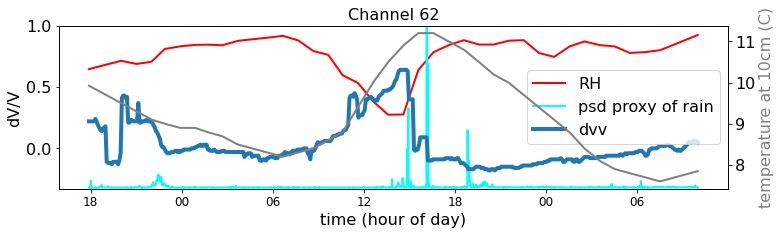

In [7]:
with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'r') as f:
    moisture = f['moisture'][:]
    dvv = f['dvv'][18]
    psd = f['psd_rain'][:]-0.0006
    temp = f['temperature'][:]

s=moisture/100*2-1
    
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(moisture)), s, label='RH', color='r', lw=2)
plt.plot(np.arange(len(psd)), psd * 5-0.32, label='psd proxy of rain', color='cyan', lw=2)
plt.plot(np.arange(len(dvv)), dvv-1, label='dvv', lw=4)
plt.ylim(-0.33, 1)
plt.xlabel("time (hour of day)", fontsize = 16)
plt.ylabel("dV/V", fontsize = 16)
plt.xticks(xax, hrax, fontsize = 12)
plt.title("Channel 62", fontsize = 16)
plt.legend()
twinx = plt.twinx()
twinx.plot(np.arange(2408), temp, color='gray', lw=2, label='temperature')

twinx.set_ylabel("temperature at 10cm (C)", fontsize=16, color='gray')

## Data 2:
#### Weather station's air temperature, air humidity and wind speed

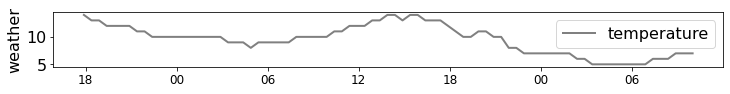

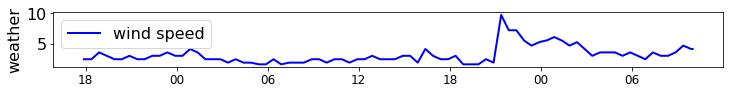

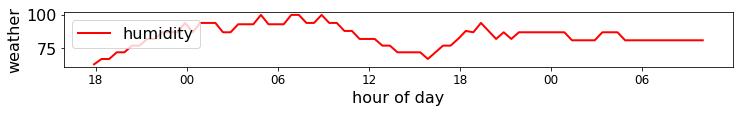

In [10]:
csv_file = pd.read_csv('met_newport.csv')
air_temp = csv_file['Temperature'].to_numpy()
wind_speed = csv_file['Wind Speed'].to_numpy()*1000/3600
humidity = csv_file['Humidity'].to_numpy()

air_temp_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(air_temp) * 30, 30), air_temp)
wind_speed_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(wind_speed) * 30, 30), wind_speed)
humidity_interpolated = np.interp(np.arange(0, 2408), np.arange(0, len(humidity) * 30, 30), humidity)

plt.figure(figsize=(12, 1))
plt.plot(np.arange(2408), air_temp_interpolated, label='temperature', color='gray', lw=2)
plt.ylabel("weather", fontsize = 16)
plt.xticks(xax, hrax, fontsize = 12)
plt.legend()
plt.figure(figsize=(12, 1))
plt.plot(np.arange(2408), wind_speed_interpolated, label='wind speed', color='blue', lw=2)
plt.ylabel("weather", fontsize = 16)
plt.xticks(xax, hrax, fontsize = 12)
plt.legend()
plt.figure(figsize=(12, 1))
plt.plot(np.arange(2408), humidity_interpolated, label='humidity', color='r', lw=2)
plt.xlabel("hour of day", fontsize = 16)
plt.ylabel("weather", fontsize = 16)
plt.xticks(xax, hrax, fontsize = 12)
plt.legend()

## 1. Hydrological models

### 1.1 The evaporation slope

During the evaporation period, the water balance is mainly sensitive to the solar radiation and temperature.

This simple model gives bounds for the evaporation coefficient. 

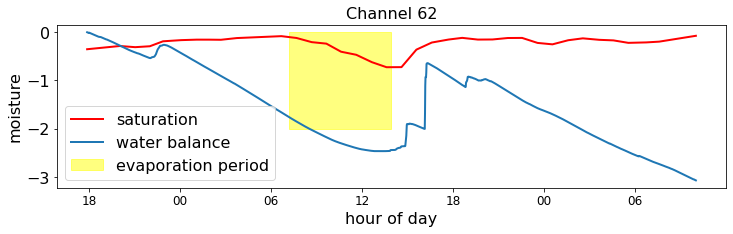

In [11]:
## This model assumes a uniform moisture at the surface and the depth
## The moisture is from the measured RH data
class hydro:
    def __init__(self, prec, porosity, s, T, I, till, tire, A_p, A_e, A_d):
        self.prec = prec
        self.s = (s-0.28)/0.62
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.till = till
        self.tire = tire
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d

        ## evaporation
        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239
        self.pet = 1.6 * np.power((10*self.T / self.I), self.a)
        self.evap = self.pet * self.s * self.till * self.tire   ## Evaporation rate

        ## drainage
        self.drain = self.prec * self.s * self.till * self.tire  ## Drainage rate

    def get_s_rate(self):
        prec_rate = self.A_p * self.prec
        evap_rate = self.A_e * self.evap
        drain_rate = self.A_d * self.drain
        s_rate = prec_rate - evap_rate - drain_rate

        return s_rate, prec_rate, evap_rate, drain_rate, self.pet

s_rate, prec_rate, evap_rate, drain_rate, pet = hydro(np.roll(psd, 1), 0.5, s, temp, 12, 25, 7, 0.9,0.000003,0.0000005).get_s_rate()

plt.figure(figsize=(12, 3))
plt.fill_between([800,1200], [-2,-2], [0,0], color='yellow', alpha=0.5, label='evaporation period')
plt.plot(np.arange(2408), s-1, label='saturation', color='r', lw=2)
plt.plot(np.arange(2408), np.cumsum(s_rate), label='water balance', lw=2)
plt.xticks(xax, hrax, fontsize = 12)
plt.xlabel("hour of day", fontsize = 16)
plt.ylabel("moisture", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()

### 1.2 The precipitation slope

During the precipitation period, the water balance is mainly controlled by precipitation and drainage.

This simple model test the relation between the drainage and the instant level of water saturation. 

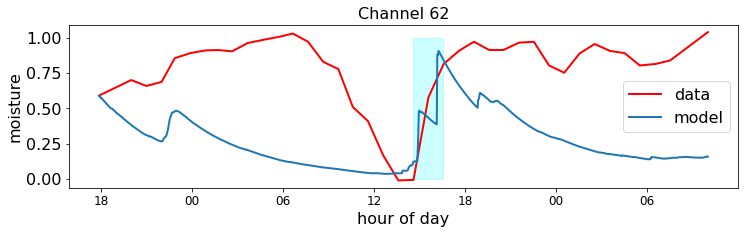

In [13]:
## This model assumes a uniform moisture at the surface and the depth
## The moisture is from the forward modelled water saturation
class hydro0:
    def __init__(self, prec, porosity, s0, T, I, till, tire, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s0
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.till = till
        self.tire = tire
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length

        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239


    def get_s_history(self):

        s_history = np.zeros(self.length)

        for i in range(self.length):
            ## evaporation
            self.pet = 1.6 * np.power((10*self.T[i] / self.I), self.a)
            self.evap = self.pet * self.s * self.till * self.tire   ## Evaporation rate

            ## drainage
            self.drain = self.prec[i] * self.s * self.till * self.tire  ## Drainage rate

            prec_rate = self.A_p * self.prec[i]
            evap_rate = self.A_e * self.evap
            drain_rate = self.A_d * self.drain
            s_rate = prec_rate - evap_rate - drain_rate
            self.s += s_rate
            s_history[i] = self.s

        return s_history
    
s_history = hydro0(np.roll(psd, 1), 0.5, (s[0]-0.28)/0.62, temp, 12, 25, 7, 1,0.000003,0.0057).get_s_history()

plt.figure(figsize=(12, 3))
plt.fill_between([1240,1360], [0,0], [1,1], color='cyan', alpha=0.2)
plt.plot(np.arange(2408), (s-0.28)/0.62, label='data', color='r', lw=2)
plt.plot(np.arange(2408), s_history, label='model', lw=2)
plt.xticks(xax, hrax, fontsize = 12)
plt.xlabel("hour of day", fontsize = 16)
plt.ylabel("moisture", fontsize = 16)
plt.title("Channel 62", fontsize = 16)
plt.legend()
        

### 1.3 The time dependent factors: ET, precipitation and drainage

In [14]:
## This model use the actual weather data to account for the evaporation
## The moisture at depth is forward modelled to account for the drainage and evaporation
## The PSD data is calibrated to model the water increase due to the rain
class hydro0_sur_piecewise:
    def __init__(self, prec, porosity, s0, s_sur, T, I, radiation, till, tire, A_p, A_e, A_d, length=2408):
        self.prec = prec
        self.s = s0
        self.s_sur = s_sur
        self.phi = porosity  ## Porosity
        self.T = T
        self.I = I
        self.radiation = radiation
        self.till = till
        self.tire = tire
        self.A_p = A_p
        self.A_e = A_e
        self.A_d = A_d
        self.length = length

        self.a = 6.75e-7 * np.power(self.I, 3) - 7.71e-5 * np.power(self.I, 2) + 1.792e-2 * self.I + 0.49239


    def get_s_history(self):

        s_history = np.zeros(self.length)

        for i in range(self.length):
            ## evaporation
            self.pet = 1.6 * np.power((10*self.T[i] / self.I), self.a)
            self.evap = self.pet * self.s * self.till * self.tire * self.radiation[i]  ## Evaporation rate

            ## drainage
            self.drain = self.prec[i] * self.s * self.till * self.tire  ## Drainage rate

            prec_rate = self.A_p * self.prec[i]
            evap_rate = self.A_e * self.evap
            drain_rate = self.A_d * self.drain
            s_rate = prec_rate - evap_rate - drain_rate
            self.s += s_rate
            s_history[i] = self.s
            # if i>1000 and i<1200:
            #     print(evap_rate)

        return s_history

## ET model

#### Extraterrestrial Radiation every hour

In [15]:
def rad_a_shortterm(lat, lon, day, lz, time, duration):
    ## Short term radiation model
    ## lat, lon in degrees
    ## day in days from 1st Jan
    ## mid-point time in hours from 00:00
    ## lz in degrees
    ## duration in hours

    lat = np.radians(lat)

    ## Solar declination
    delta = 0.4093 * np.sin(2 * np.pi * day / 365 - 1.39)

    ## Sunset hour angle
    omega_s = np.arccos(-np.tan(lat) * np.tan(delta))

    ## Earth-Sun distance
    d = 1 + 0.033 * np.cos(2 * np.pi * day / 365)

    ## Seasonal correction
    b = 2 * np.pi * (day - 81) / 364
    Sc = 0.1645 * np.sin(2 * b) - 0.1255 * np.cos(b) - 0.025 * np.sin(b)

    ## Solar time angle at mid-point time
    omega = np.pi / 12 * (time + 0.06667 * (lon - lz) + Sc - 12)

    ## Solar time angle at beginning and end of the period
    omega1 = omega - duration * np.pi / 24
    omega2 = omega + duration * np.pi / 24

    ## Extra-terrestrial radiation for this period
    Ra = 12 * 60 / np.pi * 0.0820 * d * (
            (omega2 - omega1) * np.sin(lat) * np.sin(delta) + np.cos(lat) * np.cos(delta) * (np.sin(omega2) - np.sin(omega1)))
    
    return Ra



#### get the radiation for harper

([<matplotlib.axis.XTick at 0x7f5b31c04070>,
 [Text(7, 0, '18'),
  Text(367, 0, '00'),
  Text(727, 0, '06'),
  Text(1087, 0, '12'),
  Text(1447, 0, '18'),
  Text(1807, 0, '00'),
  Text(2167, 0, '06')])

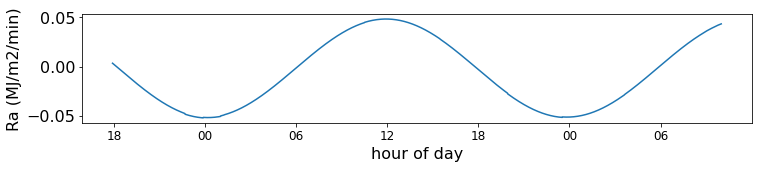

In [17]:
lat = 52.78
lon = -2.43
day = 76   ## 17th March
lz = 0  
time = 12.0
duration = 1.0/60  ## 1 minute
rad_a_shortterm(lat, lon, day, lz, time, duration)

rad_every_minute = np.zeros(acqu_time.shape[0])
for imin in range(0, acqu_time.shape[0]):
    day = acqu_time[imin].timetuple().tm_yday
    time = acqu_time[imin].hour + acqu_time[imin].minute/60
    rad_every_minute[imin] = rad_a_shortterm(lat, lon, day, lz, time, 1.0/60)
    
plt.figure(figsize=(12, 2))
plt.plot(np.arange(acqu_time.shape[0]), rad_every_minute, label='1-minute radiation')
plt.xlabel("hour of day", fontsize = 16)
plt.ylabel("Ra (MJ/m2/min)", fontsize = 16)
plt.xticks(xax, hrax, fontsize = 12)

#### Reference evapotranspiration derived from Ra, wind speed, air temperature and humidity

In [18]:
def eto_shortterm(rad, T, wind, RH):
    ## Short term ETo model
    ## rad in MJ/m2/min
    ## T in C
    ## wind in m/s
    ## RH in %

    ## Saturation vapour pressure
    es = 0.6108 * np.exp(17.27 * T / (T + 237.3))

    ## Actual vapour pressure
    ea = es * RH / 100

    ## Slope of the saturation vapour pressure curve
    delta = 4098 * es / np.power(T + 237.3, 2)

    ## Psychrometric constant
    gamma = 0.665e-3 * 101.325

    ## ETo
    ETo = (0.408 * delta * rad + gamma * 900/24/60 / (T + 273) * wind * (es - ea)) / (delta + gamma * (1 + 0.34 * wind))

    return ETo

## Combining the ET, precipitation and drainage

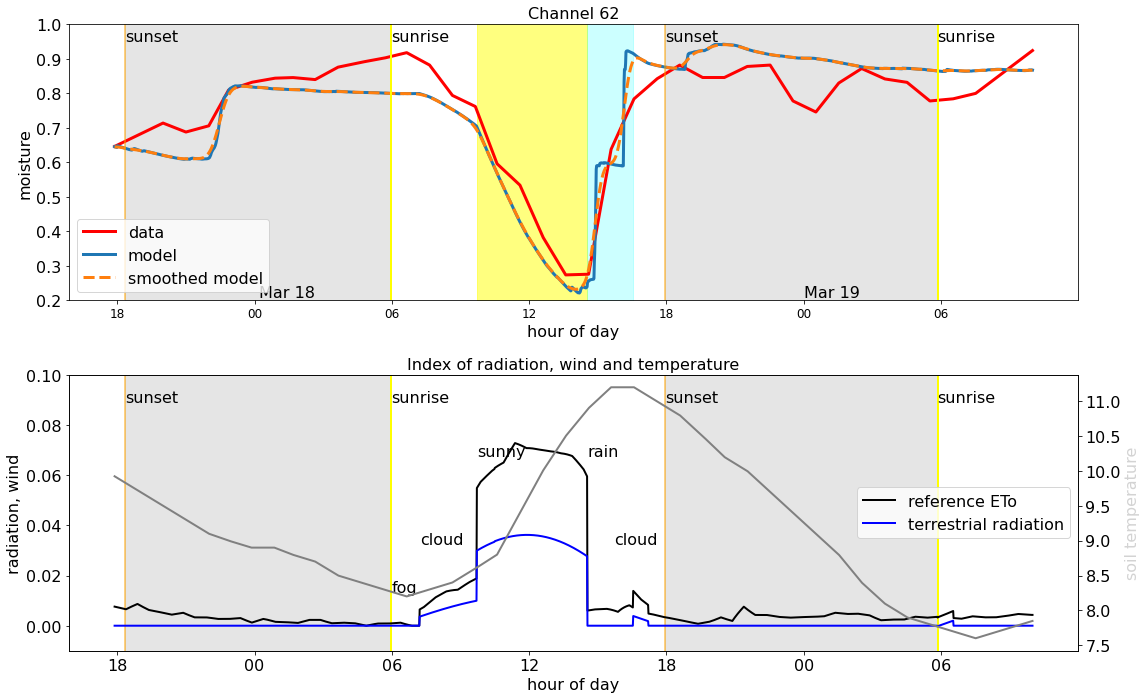

In [19]:
A_e = 0.0015
rad = np.zeros(2408)
rad[800:950] = 0.25
rad[950:1240] = 0.75
rad[1360:1400] = 0.25
rad[2158:2200] = 0.25
rad = rad * rad_every_minute
eto_every_minute=eto_shortterm(rad, air_temp_interpolated, wind_speed_interpolated*0.75, humidity_interpolated)


A_d = 0.01
A_p = 0.9


### calibrate the psd data
ave_psd = np.zeros_like(psd)
for i in range(len(psd)):
    if i >1300 and i < 1800:
        ave_psd[i] = psd[i] / 2
    else:
        ave_psd[i] = psd[i]

s_history = hydro0_sur_piecewise(ave_psd, 0.5, s[0], s, temp, 9, eto_every_minute, 9.5, 6.7, A_p,A_e,A_d).get_s_history()

s_history_smooth = gaussian_filter1d(s_history, sigma=15, mode='reflect')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Model the water balance
ax1.fill_between(np.arange(2408), 0, 1, where=eto_every_minute > 0.002, color='yellow', alpha=0.5)
ax1.fill_between([1240,1360], [0,0], [1,1], color='cyan', alpha=0.2)
ax1.fill_between([27,726], [0,0], [1,1], color='gray', alpha=0.2)
ax1.fill_between([1443,2158], [0,0], [1,1], color='gray', alpha=0.2)
ax1.plot(np.arange(2408), s, label='data', color='r', lw=3)
ax1.plot(np.arange(2408), s_history, label='model', lw=3)
ax1.plot(np.arange(2408), s_history_smooth, label='smoothed model', linestyle='--', lw=3)
ax1.set_ylim(0.2, 1)
ax1.set_xlabel("hour of day", fontsize=16)
ax1.set_ylabel("moisture", fontsize=16)
ax1.set_xticks(xax)
ax1.set_xticklabels(hrax, fontsize=12)
ax1.set_title("Channel 62", fontsize=16)
ax1.legend()
ax1.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax1.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax1.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax1.text(27, 0.95, 'sunset', color='k')
ax1.text(726, 0.95, 'sunrise', color='k')
ax1.text(1443, 0.95, 'sunset', color='k')
ax1.text(2158, 0.95, 'sunrise', color='k')
ax1.text(Ind6hrs[1] + 20, 0.21, 'Mar 18', color='k')
ax1.text(Ind6hrs[5] + 30, 0.21, 'Mar 19', color='k')

# Weather data
ax2.fill_between([27,726], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax2.fill_between([1443,2158], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
ax2.set_ylim(-0.01, 0.1)
ax2.text(726, 0.5/37, 'fog', color='k')
ax2.text(800, 1.2/37, 'cloud', color='k')
ax2.text(950, 2.5/37, 'sunny', color='k')
ax2.text(1240, 2.5/37, 'rain', color='k')
ax2.text(1310, 1.2/37, 'cloud', color='k')
ax2.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
ax2.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
ax2.text(27, 3.3/37, 'sunset', color='k')
ax2.text(726, 3.3/37, 'sunrise', color='k')
ax2.text(1443, 3.3/37, 'sunset', color='k')
ax2.text(2158, 3.3/37, 'sunrise', color='k')
ax2.plot(np.arange(2408), eto_every_minute*10, color='k', lw=2, label='reference ETo')
ax2.plot(np.arange(2408), rad, color='b', lw=2, label='terrestrial radiation')
ax2.set_xticks(xax)
ax2.set_xticklabels(hrax, fontsize=16)
ax2.set_xlabel("hour of day", fontsize=16)
ax2.set_ylabel("radiation, wind", fontsize=16)
ax2.set_title("Index of radiation, wind and temperature", fontsize=16)
ax2.legend(loc='center right')

twinx = ax2.twinx()
twinx.plot(np.arange(2408), temp, color='gray', lw=2, label='temperature')
twinx.set_ylabel("soil temperature", fontsize=16, color='lightgray')

plt.tight_layout()
plt.show()

### Model the elastic properties

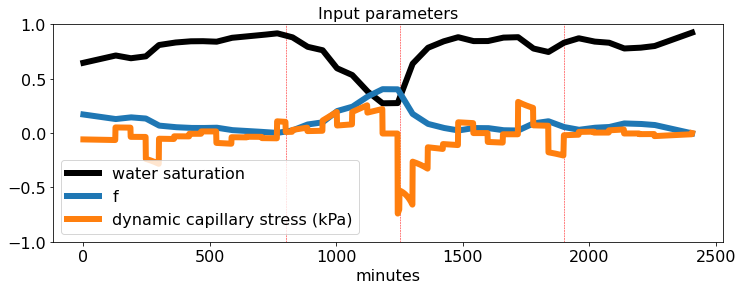

In [21]:
## Input parameters
scale_factor = moisture/100 * 2.5 - 0.6
new_f = 0.9-scale_factor/2
s=moisture/100*2-1

s_wr = 0.27  ## residual saturation
   
tau1 = 5e6 * np.exp(np.power(s[0:800],3))  ## wetting
tau2 = 1e7 * (1-s[800:1250])  ## drying
tau3 = 5e6 * np.exp(np.power(s[1250:1900],3))  ## wetting
tau4 = 1e7 * (1-s[1900:])  ## drying
tau = np.concatenate((tau1, tau2, tau3, tau4))

s_rate = np.diff(s) / 60 ## Saturation rate, per second
p_diff = 0-np.concatenate((s_rate, [0])) * tau

plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(moisture)), s, label='water saturation', color='k', lw=6)
plt.plot(np.arange(len(new_f)), new_f, label='f', lw=6)
plt.plot(np.arange(len(p_diff)), p_diff/1000, label='dynamic capillary stress (kPa)', lw=6)

plt.ylim(-1, 1)

for time_min in [800, 1250, 1900]:
    plt.vlines(time_min, -1, 1, color='r', lw=0.5, ls='--')
plt.xlabel("minutes", fontsize = 16)
plt.title("Input parameters", fontsize = 16) 
plt.legend()

In [22]:
class litho:
    def __init__(self, bulk_density, porosity, N, f, s, s_wr, tau, igore_capillary=False):
        self.rho_d = bulk_density
        self.phi = porosity  ## derived from rho_d, actually
        self.N = N  ## number of contacts
        self.f = f  ## non-slip fraction
        self.s = s  ## Saturation (water / (air + water))
        self.s_wr = s_wr  ## residual saturation
        self.tau = tau  ## dynamic coefficient of capillary pressure

        ## Solid grains
        self.rho_s = 2650 # kg/m^3
        self.K_s = 37e9 # Pa
        self.G_s = 44e9 # Pa

        ## Water
        self.rho_w = 1000
        self.K_w = 2.2e9  ## by Copilot

        ## Air
        self.rho_a = 1.2  ## kg/m^3
        self.K_a = 1e5  ## by Copilot

        ## Water-air mixture
        self.K_f = 1 / (self.s / self.K_w  +  (1-self.s) / self.K_a)

        ## Effective density of the soil
        self.rho = (1-self.phi)*self.rho_s + self.phi*(self.s*self.rho_w + (1-self.s)*self.rho_a)

        ## Capillary and pore pressure
        if igore_capillary:  ## typical for fully saturated soil
            P_e = (self.rho - self.rho_w) * 9.8 * 0.1
        else:
            kai = (self.s - self.s_wr) / (1 - self.s_wr)
            s_rate = np.diff(self.s) / 60  ## Saturation rate, per second
            P_cdiff = np.concatenate((s_rate, [0])) * self.tau
            P_e = (self.rho - self.rho_a) * 9.8 * 0.1 - (self.rho_w - self.rho_a) * 9.8 * 0.1 * kai - P_cdiff

        ## Moduli of frame (Hertz-Mindlin) 
        nu = (3*self.K_s-2*self.G_s)/(2*(3*self.K_s+self.G_s))  ## Poisson's ratio
        self.K_d = (self.N**2 * (1-self.phi)**2 * self.G_s**2 / (18*np.pi**2 * (1-nu)**2) * P_e)**(1/3)
        self.G_d = 3 * self.K_d * (2+3*self.f-(1+3*self.f)*nu) / (2 - nu) / 5

    def get_vp_vs(self):
        
        self.K = self.K_d + (1-self.K_d/self.K_s)**2 / (self.phi/self.K_f + (1-self.phi)/self.K_s - self.K_d/self.K_s**2)
        self.G = self.G_d
        self.vp = np.sqrt((self.K + 4*self.G/3)/self.rho)
        self.vs = np.sqrt(self.G/self.rho)

        return self.vp, self.vs, self.K, self.G, self.rho

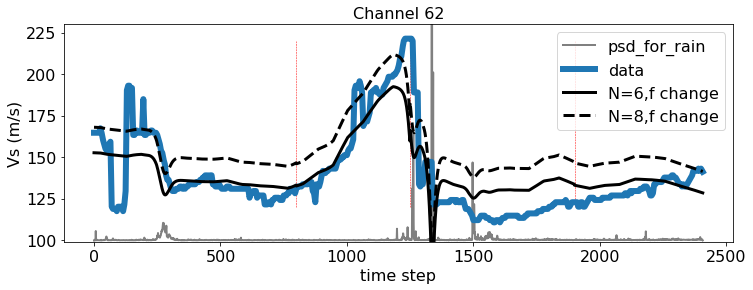

In [23]:
bulk_density, porosity = 1400, 0.47
vp_sand, vs_sand, _, _, _ = litho(bulk_density, porosity, 6, new_f, s_history_smooth, s_wr, tau).get_vp_vs()
vp_sand1, vs_sand1, _, _, _ = litho(bulk_density, porosity, 6, 0.0, s_history_smooth, s_wr, tau).get_vp_vs()
vp_sand2, vs_sand2, _, _, _ = litho(bulk_density, porosity, 6, 0.2, s_history_smooth, s_wr, tau).get_vp_vs()
vp_sand3, vs_sand3, _, _, _ = litho(bulk_density, porosity, 6, 0.4, s_history_smooth, s_wr, tau).get_vp_vs()
vp_clay, vs_clay, _, _, _ = litho(bulk_density, porosity, 8, new_f, s_history_smooth, s_wr, tau).get_vp_vs()
vp_clay1, vs_clay1, _, _, _ = litho(bulk_density, porosity, 8, 0.0, s_history_smooth, s_wr, tau).get_vp_vs()
vp_clay2, vs_clay2, _, _, _ = litho(bulk_density, porosity, 8, 0.2, s_history_smooth, s_wr, tau).get_vp_vs()
vp_clay3, vs_clay3, _, _, _ = litho(bulk_density, porosity, 8, 0.4, s_history_smooth, s_wr, tau).get_vp_vs()


plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(psd)), psd * 500+100, label='psd_for_rain', color='gray', lw=2)

plt.plot(np.arange(len(dvv)), dvv*135, label='data', lw=6)
plt.plot(np.arange(len(moisture)), vs_sand, label='N=6,f change', color='k', lw=3)
plt.plot(np.arange(len(moisture)), vs_clay, label='N=8,f change', color='k', lw=3, ls='--')

for time_min in [800, 1250, 1900]:
    plt.vlines(time_min, 120, 220, color='r', lw=0.5, ls='--')
plt.xlabel("time step", fontsize = 16)
plt.ylabel("Vs (m/s)", fontsize = 16)
plt.ylim(99, 230)
plt.title("Channel 62", fontsize = 16)
plt.legend(loc='upper right')

# Spatial pattern: 
## applying the hydrology + lithology model to several channels

#### First, read the tillage depth and tire pressure that averaged every 5 channels

9.489134094732018 6.719460686666209
12.398028571275024 6.83811784503888
12.2269347719851 9.032685407108897
6.958668722451065 8.75621187614566


Text(0.5, 0, 'channel (+50)')

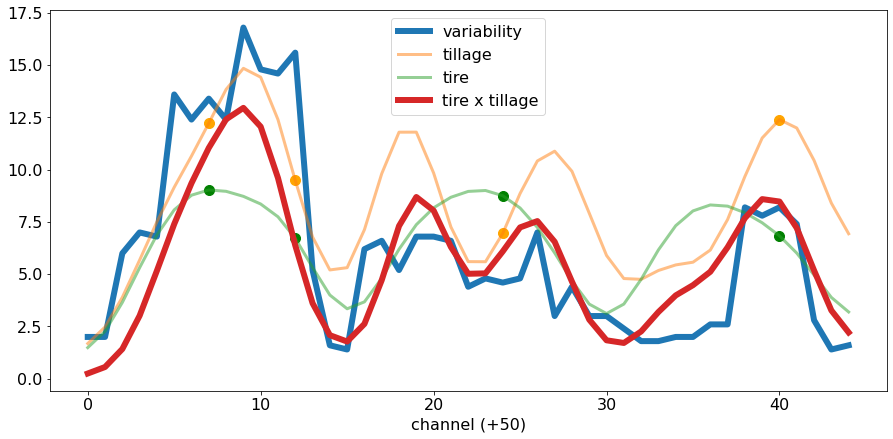

In [25]:
### Read the data from the interpolated file
tillage_interpolated = pd.read_csv('/fd1/QibinShi_data/England_farm/interp_dv_b_tillage_tire.csv')['tillage_depth'].to_numpy()
tire_interpolated = pd.read_csv('/fd1/QibinShi_data/England_farm/interp_dv_b_tillage_tire.csv')['tire_pressure'].to_numpy()
dvv_variability = pd.read_csv('/fd1/QibinShi_data/England_farm/interp_dv_b_tillage_tire.csv')['dvv_varibility'].to_numpy()

### plot the spatial variability
plt.figure(figsize=(15, 7))
plt.plot(np.arange(45), dvv_variability*20+1, label='variability', lw=6)
plt.plot(np.arange(45), tillage_interpolated, label='tillage', lw=3, alpha=0.5)
plt.plot(np.arange(45), tire_interpolated, label='tire', lw=3, alpha=0.5)
plt.plot(np.arange(45), tire_interpolated*tillage_interpolated/10, label='tire x tillage', lw=6)

### pick sevaral locations
channel_list = [12, 40, 7, 24]
for ch in channel_list:
    plt.scatter([ch], [tillage_interpolated[ch]], color='orange', s=100)
    plt.scatter([ch], [tire_interpolated[ch]], color='green', s=100)
    print(tillage_interpolated[ch], tire_interpolated[ch])

plt.legend(loc='upper center')
plt.xlabel("channel (+50)", fontsize = 16)



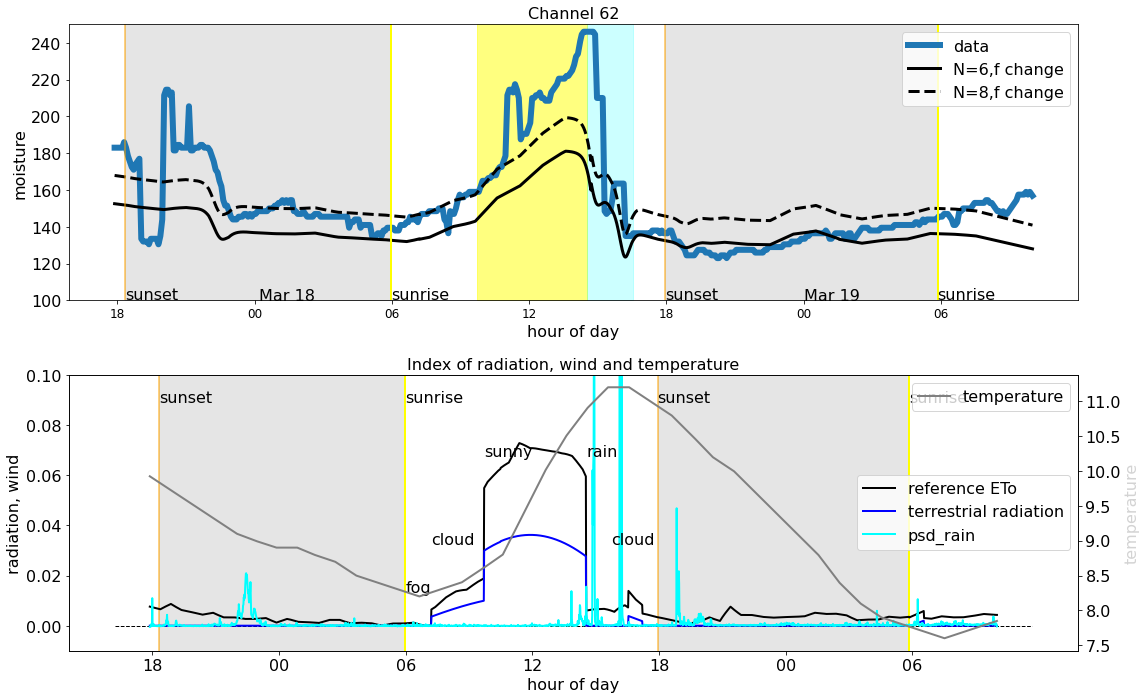

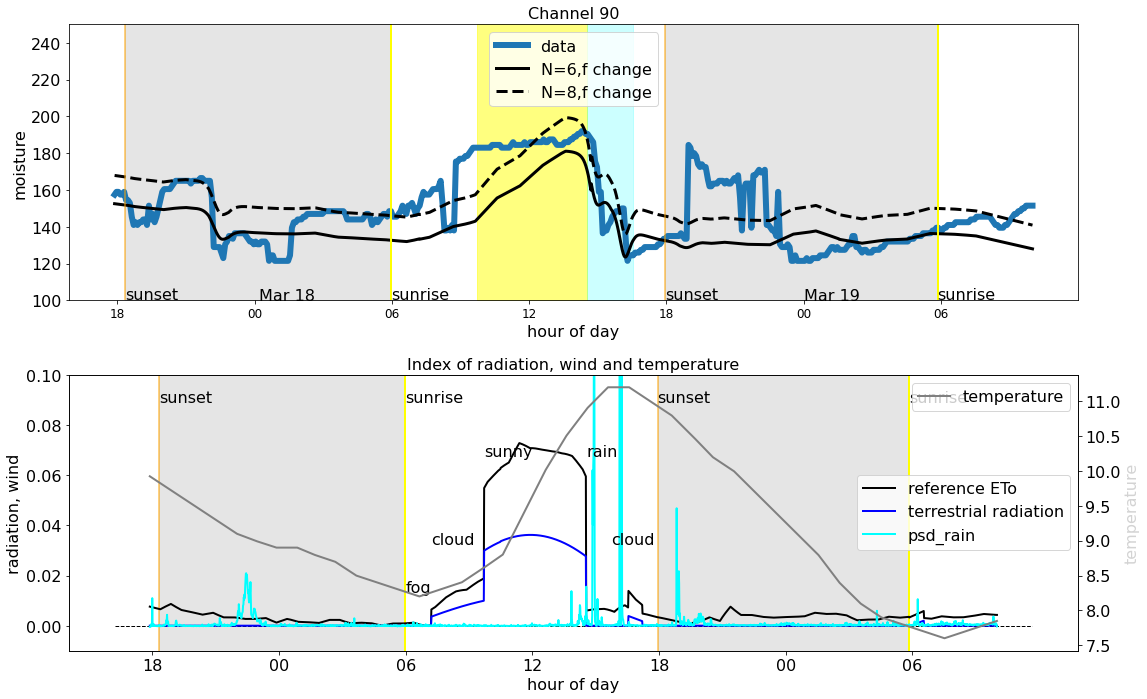

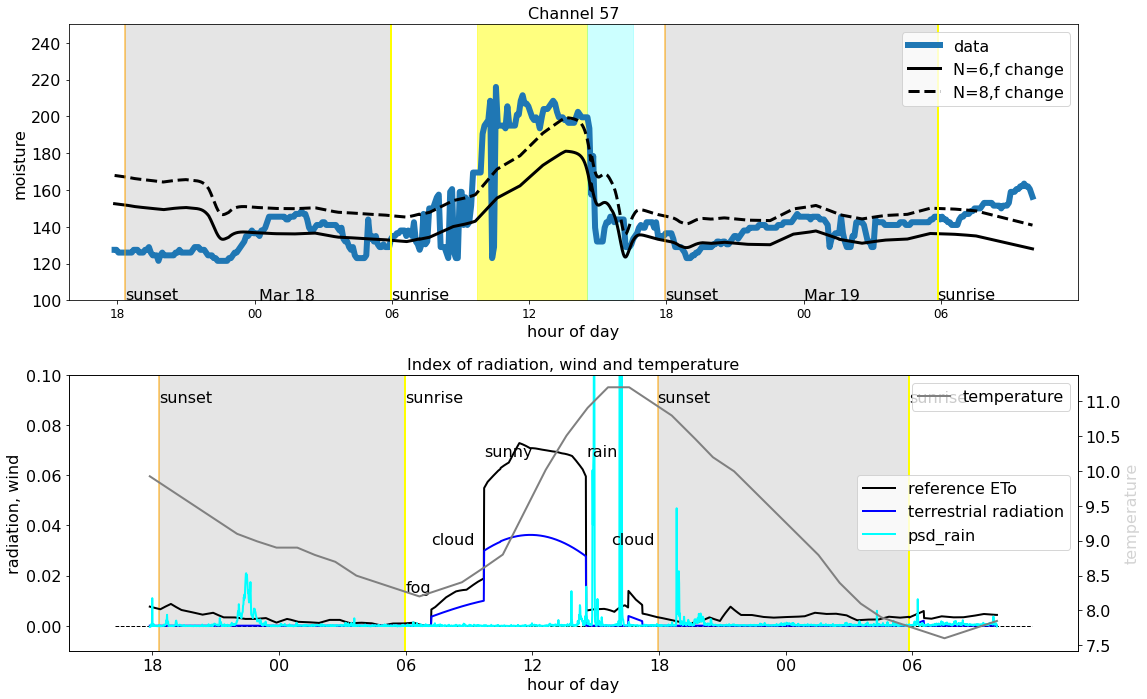

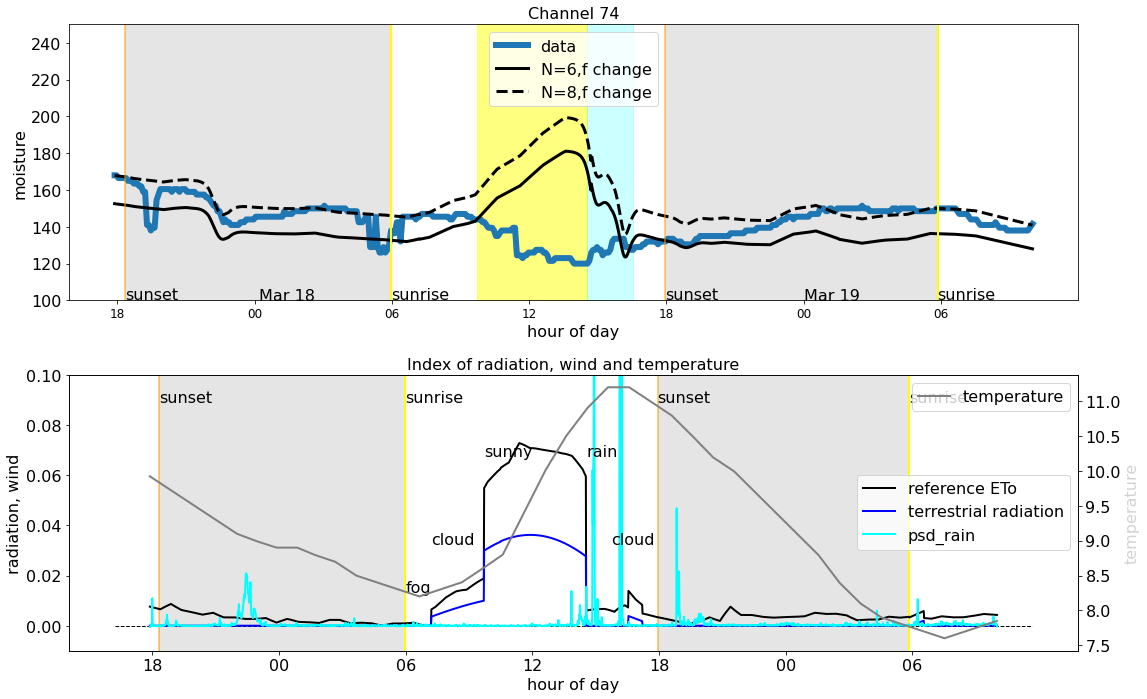

In [27]:
for ch in channel_list:
    with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'r') as f:
        dvv = f['dvv'][ch+6]

    A_e = 0.0015
    rad = np.zeros(2408)
    rad[800:950] = 0.25
    rad[950:1240] = 0.75
    rad[1360:1400] = 0.25
    rad[2158:2200] = 0.25
    rad = rad * rad_every_minute
    eto_every_minute=eto_shortterm(rad, air_temp_interpolated, wind_speed_interpolated*0.75, humidity_interpolated)


    A_d = 0.01
    A_p = 0.9


    ### calibrate the psd data
    ave_psd = np.zeros_like(psd)
    for i in range(len(psd)):
        if i >1300 and i < 1800:
            ave_psd[i] = psd[i] / 2
        else:
            ave_psd[i] = psd[i]

    ################## hydrology model
    s_history = hydro0_sur_piecewise(ave_psd, 0.5, s[0], s, temp, 9, eto_every_minute*0.3, 12.4, 6.8, A_p,A_e,A_d).get_s_history()

    s_history_smooth = gaussian_filter1d(s_history, sigma=15, mode='reflect')

    ################## lithology model
    bulk_density, porosity = 1400, 0.47
    vp_sand, vs_sand, _, _, _ = litho(bulk_density, porosity, 6, new_f, s_history_smooth, s_wr, tau).get_vp_vs()
    vp_sand1, vs_sand1, _, _, _ = litho(bulk_density, porosity, 6, 0.0, s_history_smooth, s_wr, tau).get_vp_vs()
    vp_sand2, vs_sand2, _, _, _ = litho(bulk_density, porosity, 6, 0.2, s_history_smooth, s_wr, tau).get_vp_vs()
    vp_sand3, vs_sand3, _, _, _ = litho(bulk_density, porosity, 6, 0.4, s_history_smooth, s_wr, tau).get_vp_vs()
    vp_clay, vs_clay, _, _, _ = litho(bulk_density, porosity, 8, new_f, s_history_smooth, s_wr, tau).get_vp_vs()
    vp_clay1, vs_clay1, _, _, _ = litho(bulk_density, porosity, 8, 0.0, s_history_smooth, s_wr, tau).get_vp_vs()
    vp_clay2, vs_clay2, _, _, _ = litho(bulk_density, porosity, 8, 0.2, s_history_smooth, s_wr, tau).get_vp_vs()
    vp_clay3, vs_clay3, _, _, _ = litho(bulk_density, porosity, 8, 0.4, s_history_smooth, s_wr, tau).get_vp_vs()


    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

    # Model the water balance
    ax1.fill_between(np.arange(2408), 100, 250, where=eto_every_minute > 0.002, color='yellow', alpha=0.5)
    ax1.fill_between([1240,1360], [100,100], [250,250], color='cyan', alpha=0.2)
    ax1.fill_between([27,726], [100,100], [250,250], color='gray', alpha=0.2)
    ax1.fill_between([1443,2158], [100,100], [250,250], color='gray', alpha=0.2)
    # ax1.plot(np.arange(2408), 1.7-dvv, label='data', color='r', lw=3)
    # ax1.plot(np.arange(2408), s_history, label='model', lw=3)
    # ax1.plot(np.arange(2408), s_history_smooth, label='smoothed model', linestyle='--', lw=3)
    ax1.set_ylim(100, 250)

    ax1.plot(np.arange(len(dvv)), dvv*150, label='data', lw=6)
    ax1.plot(np.arange(len(moisture)), vs_sand, label='N=6,f change', color='k', lw=3)
    ax1.plot(np.arange(len(moisture)), vs_clay, label='N=8,f change', color='k', lw=3, ls='--')

    ax1.set_xlabel("hour of day", fontsize=16)
    ax1.set_ylabel("moisture", fontsize=16)
    ax1.set_xticks(xax)
    ax1.set_xticklabels(hrax, fontsize=12)
    ax1.set_title("Channel "+ str(ch+50), fontsize=16)
    ax1.legend()
    ax1.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
    ax1.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
    ax1.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
    ax1.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
    ax1.text(27, 100.95, 'sunset', color='k')
    ax1.text(726, 100.95, 'sunrise', color='k')
    ax1.text(1443, 100.95, 'sunset', color='k')
    ax1.text(2158, 100.95, 'sunrise', color='k')
    ax1.text(Ind6hrs[1] + 20, 100.21, 'Mar 18', color='k')
    ax1.text(Ind6hrs[5] + 30, 100.21, 'Mar 19', color='k')

    # Weather data
    ax2.fill_between([27,726], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
    ax2.fill_between([1443,2158], [-0.2,-0.2], [3.7,3.7], color='gray', alpha=0.2)
    ax2.set_ylim(-0.01, 0.1)
    ax2.text(726, 0.5/37, 'fog', color='k')
    ax2.text(800, 1.2/37, 'cloud', color='k')
    ax2.text(950, 2.5/37, 'sunny', color='k')
    ax2.text(1240, 2.5/37, 'rain', color='k')
    ax2.text(1310, 1.2/37, 'cloud', color='k')
    ax2.axvline(x=27, color='orange', linestyle='-', lw=2, alpha=0.5)
    ax2.axvline(x=726, color='yellow', linestyle='-', lw=2, alpha=1)
    ax2.axvline(x=1443, color='orange', linestyle='-', lw=2, alpha=0.5)
    ax2.axvline(x=2158, color='yellow', linestyle='-', lw=2, alpha=1)
    ax2.text(27, 3.3/37, 'sunset', color='k')
    ax2.text(726, 3.3/37, 'sunrise', color='k')
    ax2.text(1443, 3.3/37, 'sunset', color='k')
    ax2.text(2158, 3.3/37, 'sunrise', color='k')
    ax2.plot(np.arange(2408), eto_every_minute*10, color='k', lw=2, label='reference ETo')
    ax2.plot(np.arange(2408), rad, color='b', lw=2, label='terrestrial radiation')
    ax2.plot(np.arange(2408), ave_psd, color='cyan', lw=2, label='psd_rain')
    ax2.hlines(0, -100, 2508, color='k', lw=1, linestyles='--')
    ax2.set_xticks(xax)
    ax2.set_xticklabels(hrax, fontsize=16)
    ax2.set_xlabel("hour of day", fontsize=16)
    ax2.set_ylabel("radiation, wind", fontsize=16)
    ax2.set_title("Index of radiation, wind and temperature", fontsize=16)
    ax2.legend(loc='center right')

    twinx = ax2.twinx()
    twinx.plot(np.arange(2408), temp, color='gray', lw=2, label='temperature')
    twinx.set_ylabel("temperature", fontsize=16, color='lightgray')
    twinx.legend()

    plt.tight_layout()
    plt.show()